In [1]:
import pynucastro as pyna

In [2]:
rl = pyna.ReacLibLibrary()

## Unapproximated version

In [3]:
lib = rl.linking_nuclei(["fe52", "fe53", "fe54", "n"])

In [4]:
rc = pyna.PythonNetwork(libraries=[lib])
rc.write_network("ncapture.py")

In [5]:
import ncapture

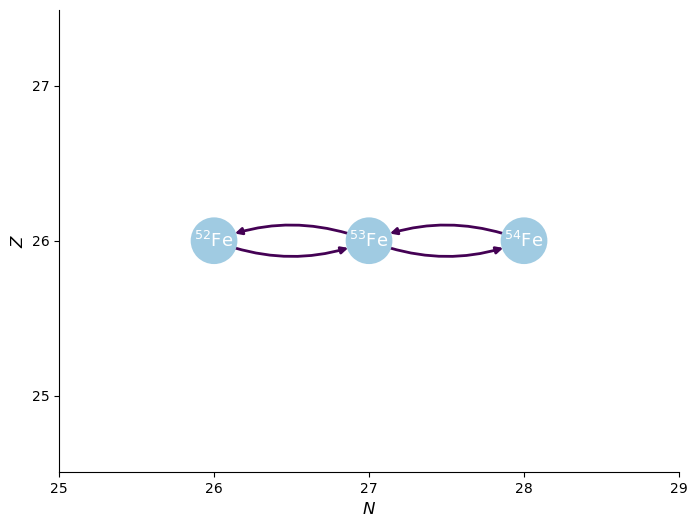

In [6]:
fig = rc.plot(curved_edges=True)

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [8]:
rho = 1.e9
T = 3.e9

X0 = np.zeros(ncapture.nnuc)
X0[ncapture.jn] = 0.5
X0[ncapture.jfe52] = 0.5
Y0 = X0 / ncapture.A

In [9]:
tmax = 1.e-5
sol = solve_ivp(ncapture.rhs, [0, tmax], Y0, method="BDF", jac=ncapture.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-8)

Text(0, 0.5, 'X')

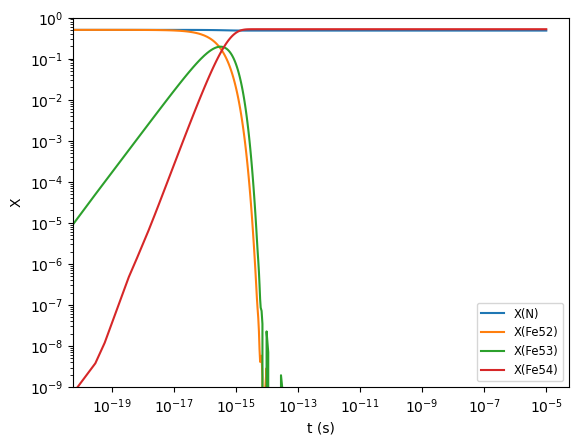

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(ncapture.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * ncapture.A[i], label=f"X({ncapture.names[i].capitalize()})")

ax.set_ylim(1.e-9, 1.0)

ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

## Approximating the double n capture

In [11]:
rf, rr = pyna.rates.create_double_neutron_capture(rl, pyna.Nucleus("fe52"), pyna.Nucleus("fe54"))

In [12]:
rf

Fe52 + n + n ⟶ Fe54 + 𝛾

In [13]:
rc2 = pyna.PythonNetwork(rates=[rf, rr])
rc2.write_network("ncapture_approx.py")

In [14]:
import ncapture_approx

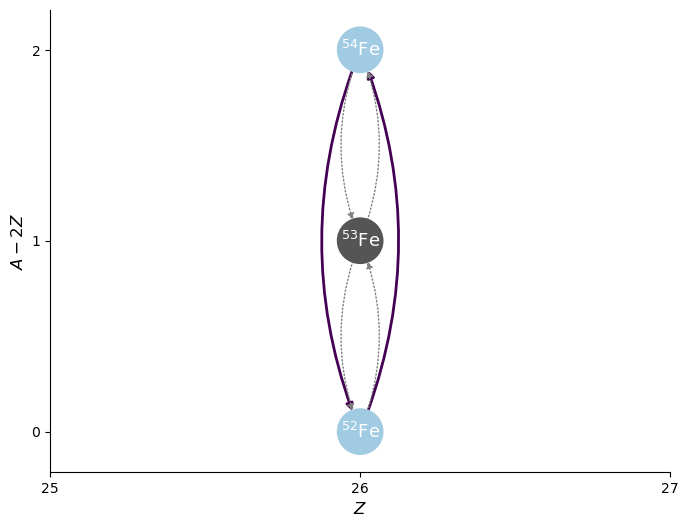

In [15]:
fig = rc2.plot(rotated=True, curved_edges=True)

In [16]:
rho = 1.e9
T = 3.e9

X0 = np.zeros(ncapture_approx.nnuc)
X0[ncapture_approx.jn] = 0.5
X0[ncapture_approx.jfe52] = 0.5
Y0 = X0 / ncapture_approx.A

In [17]:
tmax = 1.e-5
sol = solve_ivp(ncapture_approx.rhs, [0, tmax], Y0, method="BDF", jac=ncapture_approx.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-8)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x7f048b99dfa0>.
tuple index out of range
During: resolving callee type: type(CPUDispatcher(<function Fe52_n_n__Fe54__approx at 0x7f048b98a2a0>))
During: typing of call at /raid/zingale/development/pynucastro/docs/source/ncapture_approx.py (158)

Enable logging at debug level for details.

File "ncapture_approx.py", line 158:
def rhs_eq(t, Y, rho, T, screen_func):
    <source elided>
    # approximate rates
    Fe52_n_n__Fe54__approx(rate_eval, tf, rho=rho, Y=Y)
    ^


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(ncapture_approx.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * ncapture_approx.A[i], label=f"X({ncapture_approx.names[i].capitalize()})")

ax.set_ylim(1.e-9, 1.0)

ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")